In [ ]:

pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor
from category_encoders import TargetEncoder
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from sklearn.linear_model import LinearRegression

In [ ]:
train = pd.read_csv('./train.csv')
test  = pd.read_csv('./test.csv')

In [ ]:
# 파생변수 만들기

## 숫자형 컬럼을 명시적으로 float 타입으로 변환
numeric_cols = ['연매출(억원)', '총 투자금(억원)', '기업가치(백억원)']
for col in numeric_cols:
    train[col] = pd.to_numeric(train[col], errors='coerce').astype(float)
    test[col]  = pd.to_numeric(test[col], errors='coerce').astype(float)

# 회사_나이
train['회사_나이']  = 2025 - train['설립연도']
test ['회사_나이'] = 2025 - test ['설립연도']

# 투자효율 (연매출 ÷ (총 투자금 + 1))
train['투자효율']   = train['연매출(억원)'] / (train['총 투자금(억원)'] + 1)
test ['투자효율']   = test ['연매출(억원)']  / (test ['총 투자금(억원)'] + 1)

# 고객당 매출 (연매출 ÷ (고객수 + 1))
train['고객당_매출'] = train['연매출(억원)'] / (train['고객수(백만명)'] + 1)
test ['고객당_매출'] = test ['연매출(억원)']  / (test ['고객수(백만명)'] + 1)

# 원당 매출 (연매출 ÷ (직원 수 + 1))
train['직원당_매출'] = train['연매출(억원)'] / (train['직원 수'] + 1)
test ['직원당_매출'] = test ['연매출(억원)']  / (test ['직원 수'] + 1)





# 필요한 데이터 전처리 후 모델에 적용


# 로그 변환 (왜곡 안정화)
for col in numeric_cols:
    train[f'log_{col}'] = np.log1p(train[col].fillna(0.0))
    test [f'log_{col}'] = np.log1p(test [col].fillna(0.0))

# 생성된 피처 확인
engineered = [
    '회사_나이', '투자효율', '고객당_매출', '직원당_매출',
    'log_연매출(억원)', 'log_총 투자금(억원)', 'log_기업가치(백억원)'
]
print(train[engineered].head())


   회사_나이       투자효율      고객당_매출    직원당_매출  log_연매출(억원)  log_총 투자금(억원)  \
0     16   1.415330   83.578947  1.154349     8.469053       8.121480   
1      2   0.068550    3.444444  0.066939     5.634790       8.311398   
2      7   1.881159  220.745455  3.875199     9.404426       8.772455   
3      9  15.836336         NaN  3.249230     9.263692       6.501290   
4      5  11.819277  103.263158  4.979695     9.191259       6.721426   

   log_기업가치(백억원)  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


In [ ]:
train.columns

Index(['ID', '설립연도', '국가', '분야', '투자단계', '직원 수', '인수여부', '상장여부', '고객수(백만명)',
       '총 투자금(억원)', '연매출(억원)', 'SNS 팔로워 수(백만명)', '기업가치(백억원)', '성공확률', '회사_나이',
       '투자효율', '고객당_매출', '직원당_매출', 'log_연매출(억원)', 'log_총 투자금(억원)',
       'log_기업가치(백억원)'],
      dtype='object')

In [ ]:
# 가중치 변경

# 빈도 기반 샘플 가중치 생성
counts = train['성공확률'].value_counts()
train['weight'] = train['성공확률'].map(lambda y: 1/counts[y])
train['weight'] /= train['weight'].mean()

# 수치형 컬럼명 정의 & 결측 플래그 파생
numeric_cols = train.select_dtypes(include=['int64','float64']) \
                    .columns.drop(['성공확률','weight'])
for col in numeric_cols:
    train[f'is_na_{col}'] = train[col].isna().astype(int)
    test [f'is_na_{col}'] = test [col].isna().astype(int)

# 범주형 NaN → 'Missing'
cat_cols = train.select_dtypes(include=['object']) \
                .columns.drop('ID', errors='ignore')
train[cat_cols] = train[cat_cols].fillna('Missing')
test [cat_cols] = test [cat_cols].fillna('Missing')

# 평가 함수 정의
def weighted_mae(y_true, y_pred, w):
    return np.sum(w * np.abs(y_true - y_pred)) / np.sum(w)

# Imputer 비교 설정 (Median vs KNN)
imputers = {
    'median': SimpleImputer(strategy='median'),
    'knn'   : KNNImputer(n_neighbors=5)
}

features = (
    list(numeric_cols)
  + [f'is_na_{c}' for c in numeric_cols]
  + list(cat_cols)
)

results = []

for name, imp in imputers.items():
    # 전처리 파이프라인
    preprocessor = ColumnTransformer([
        ('num',  imp,                           numeric_cols.tolist()),
        ('flag', SimpleImputer(fill_value=0),  [f'is_na_{c}' for c in numeric_cols]),
        ('cat',  OneHotEncoder(handle_unknown='ignore'), cat_cols.tolist())
    ])
    pipe = Pipeline([
        ('prep', preprocessor),
        ('rf',   RandomForestRegressor(
                     n_estimators=100,
                     max_depth=6,
                     random_state=42
                 ))
    ])

    # 5-Fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    X = train[features]
    y = train['성공확률']
    w = train['weight']

    for tr_ix, va_ix in kf.split(X):
        pipe.fit(
            X.iloc[tr_ix], y.iloc[tr_ix],
            rf__sample_weight=w.iloc[tr_ix]
        )
        preds = pipe.predict(X.iloc[va_ix])
        cv_scores.append(weighted_mae(y.iloc[va_ix], preds, w.iloc[va_ix]))

    results.append((name, np.mean(cv_scores)))

#결과 출력
results_df = pd.DataFrame(results, columns=['Imputer','Mean CV wMAE'])
print(results_df)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['기업가치(백억원)']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['기업가치(백억원)']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['기업가치(백억원)']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['기업가치(백억원)']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packa

  Imputer  Mean CV wMAE
0  median      0.211957
1     knn      0.212027


In [ ]:
# model 풀 확장 : catboost, xgboost
# 모델 정의
models = {
    'CatBoost': CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        eval_metric='MAE',
        random_seed=42,
        verbose=False
    ),
    'XGBoost': XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        objective='reg:squarederror',
        random_state=42
    )
}

# 5-Fold CV 수행
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, mdl in models.items():
    cv_scores = []
    for tr_idx, va_idx in kf.split(train):
        X_tr = train.iloc[tr_idx][features]
        y_tr = train.iloc[tr_idx]['성공확률']
        w_tr = train.iloc[tr_idx]['weight']

        X_va = train.iloc[va_idx][features]
        y_va = train.iloc[va_idx]['성공확률']
        w_va = train.iloc[va_idx]['weight']

        # 파이프라인은 이미 preprocessor 변수로 정의되어있음
        pipe = Pipeline([
            ('prep', preprocessor),
            (name, mdl)
        ])

        # sample_weight 파라미터는 모델마다 이름이 다르므로
        sw_param = {f'{name}__sample_weight': w_tr.values}
        pipe.fit(X_tr, y_tr, **sw_param)

        preds = pipe.predict(X_va)
        # weighted_mae 함수도 이미 정의되어있으니까
        cv_scores.append(weighted_mae(y_va.values, preds, w_va.values))

    results[name] = np.mean(cv_scores)

# 결과 출력
for name, score in results.items():
    print(f'{name} Mean CV Weighted MAE: {score:.4f}')

CatBoost Mean CV Weighted MAE: 0.2129
XGBoost Mean CV Weighted MAE: 0.2144


In [ ]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

# 사용할 변수들만 선택
selected_features = [
    '연매출(억원)', '직원 수', '고객수(백만명)', '총 투자금(억원)', '기업가치(백억원)',
    '투자효율', '직원당_매출', 'SNS 팔로워 수(백만명)'
]
X=train[selected_features]
y=train['성공확률']
w=train["weight"]

# 모델 정의
models = {
    'CatBoost': CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        eval_metric='MAE',
        random_seed=42,
        verbose=False
    ),
    'XGBoost': XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        objective='reg:squarederror',
        random_state=42
    )
}

# 5-Fold CV 수행
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

# 전처리 파이프라인을 활용하여 데이터 전처리
for name, mdl in models.items():
    cv_scores = []
    for tr_idx, va_idx in kf.split(train):
        # 선택된 변수들만 사용
        X_tr = train.iloc[tr_idx][features]
        y_tr = train.iloc[tr_idx]['성공확률']
        w_tr = train.iloc[tr_idx]['weight']

        X_va = train.iloc[va_idx][features]
        y_va = train.iloc[va_idx]['성공확률']
        w_va = train.iloc[va_idx]['weight']

        # 파이프라인은 이미 preprocessor 변수로 정의되어있음
        pipe = Pipeline([
            ('prep', preprocessor),  # 전처리 과정
            (name, mdl)  # 모델 학습
        ])

        # sample_weight 파라미터는 모델마다 이름이 다르므로
        sw_param = {f'{name}__sample_weight': w_tr.values}
        pipe.fit(X_tr, y_tr, **sw_param)

        preds = pipe.predict(X_va)
        # weighted_mae 함수도 이미 정의되어있으니까
        cv_scores.append(weighted_mae(y_va.values, preds, w_va.values))

    results[name] = np.mean(cv_scores)

# 결과 출력
for name, score in results.items():
    print(f'{name} Mean CV Weighted MAE: {score:.4f}')



CatBoost Mean CV Weighted MAE: 0.2129
XGBoost Mean CV Weighted MAE: 0.2144


In [ ]:
pip install shap

In [ ]:
# model 풀 확장 : catboost
# 모델 정의
model = {
    'CatBoost': CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        eval_metric='MAE',
        random_seed=42,
        verbose=False
    )
}

# 5-Fold CV 수행
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, mdl in models.items():
    cv_scores = []
    for tr_idx, va_idx in kf.split(train):
        X_tr = train.iloc[tr_idx][features]
        y_tr = train.iloc[tr_idx]['성공확률']
        w_tr = train.iloc[tr_idx]['weight']

        X_va = train.iloc[va_idx][features]
        y_va = train.iloc[va_idx]['성공확률']
        w_va = train.iloc[va_idx]['weight']

        # 파이프라인은 이미 preprocessor 변수로 정의되어있음
        pipe = Pipeline([
            ('prep', preprocessor),
            (name, mdl)
        ])

        # sample_weight 파라미터는 모델마다 이름이 다르므로
        sw_param = {f'{name}__sample_weight': w_tr.values}
        pipe.fit(X_tr, y_tr, **sw_param)

        preds = pipe.predict(X_va)
        # weighted_mae 함수도 이미 정의되어있으니까
        cv_scores.append(weighted_mae(y_va.values, preds, w_va.values))

    results[name] = np.mean(cv_scores)

# 결과 출력
for name, score in results.items():
    print(f'{name} Mean CV Weighted MAE: {score:.4f}')

CatBoost Mean CV Weighted MAE: 0.2124


In [ ]:
#첫번쨰
import shap
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
import numpy as np

# 모델 정의
models = {
    'CatBoost': CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        eval_metric='MAE',
        random_seed=42,
        verbose=False
    )
}

# 5-Fold CV 수행
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, mdl in models.items():
    cv_scores = []
    for tr_idx, va_idx in kf.split(train):
        X_tr = train.iloc[tr_idx][features]
        y_tr = train.iloc[tr_idx]['성공확률']
        w_tr = train.iloc[tr_idx]['weight']

        X_va = train.iloc[va_idx][features]
        y_va = train.iloc[va_idx]['성공확률']
        w_va = train.iloc[va_idx]['weight']

        # 파이프라인은 이미 preprocessor 변수로 정의되어있음
        pipe = Pipeline([
            ('prep', preprocessor),
            (name, mdl)
        ])

        # sample_weight 파라미터는 모델마다 이름이 다르므로
        sw_param = {f'{name}__sample_weight': w_tr.values}
        pipe.fit(X_tr, y_tr, **sw_param)

        preds = pipe.predict(X_va)
        # weighted_mae 함수도 이미 정의되어있으니까
        cv_scores.append(weighted_mae(y_va.values, preds, w_va.values))

    results[name] = np.mean(cv_scores)

# 결과 출력
for name, score in results.items():
    print(f'{name} Mean CV Weighted MAE: {score:.4f}')

    # SHAP 분석
    model_fitted = pipe.named_steps[name]  # 훈련된 CatBoost 모델 얻기
    explainer = shap.Explainer(model_fitted)  # SHAP 분석기 생성
    shap_values = explainer(X_va)  # SHAP 값 계산

    # SHAP 값 시각화
    shap.summary_plot(shap_values, X_va)  # 중요 피처 시각화




CatBoost Mean CV Weighted MAE: 0.2124


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=30]="CT002": Cannot convert 'CT002' to float

In [ ]:
#두번
import pandas as pd
import shap
from xgboost import XGBRegressor



# X와 y 정의 (성공확률 예측)
X = train.drop(columns=['성공확률', 'weight'])  # '성공확률'과 'weight' 제외한 피처
y = train['성공확률']  # 타겟은 '성공확률'

# 범주형 변수 처리 (필요한 경우)
# 예를 들어, 범주형 변수를 원-핫 인코딩 할 수 있습니다
X = pd.get_dummies(X, drop_first=True)


/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing 

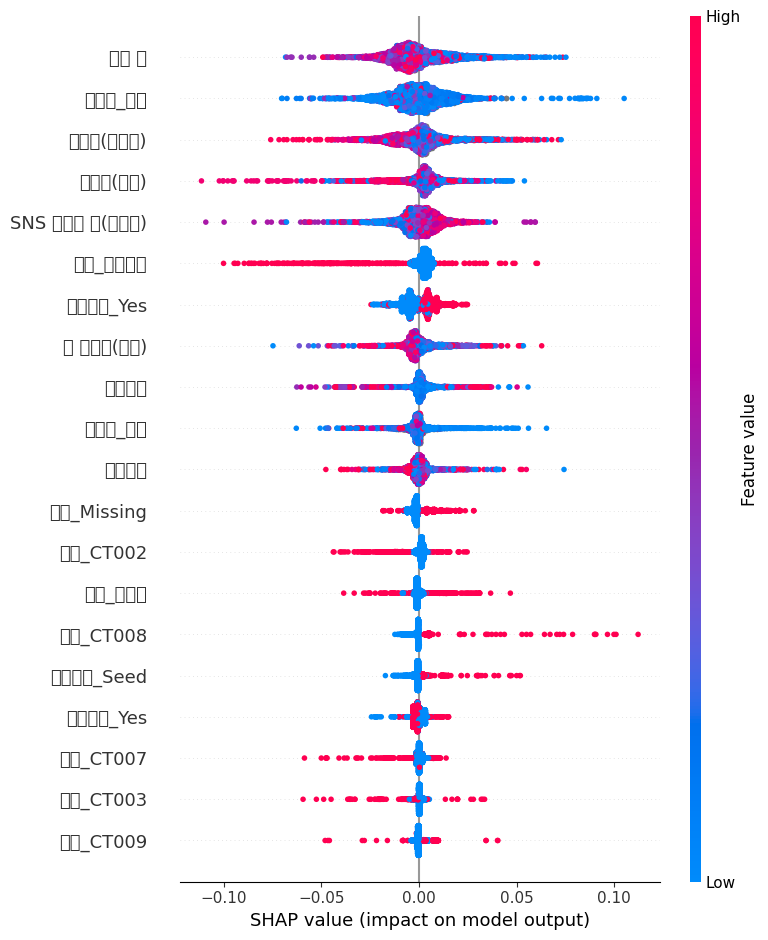

In [ ]:
# XGBoost 모델 학습
model = XGBRegressor(random_state=42)
model.fit(X, y)

# SHAP 값 계산
explainer = shap.Explainer(model)
shap_values = explainer(X)

# SHAP 값 시각화
shap.summary_plot(shap_values, X)


In [ ]:
import shap

# 모델 학습 후 SHAP 값 계산
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 각 피처별 SHAP 값의 평균 출력
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Mean SHAP value': np.abs(shap_values.values).mean(axis=0)
})

# 중요도 기준으로 정렬
feature_importance = feature_importance.sort_values(by='Mean SHAP value', ascending=False)

# 결과 출력
print(feature_importance)


             Feature  Mean SHAP value
1               직원 수         0.011300
10            직원당_매출         0.010422
2           고객수(백만명)         0.010144
4            연매출(억원)         0.007750
5     SNS 팔로워 수(백만명)         0.007317
...              ...              ...
1548   ID_TRAIN_1521         0.000000
1547   ID_TRAIN_1520         0.000000
1546   ID_TRAIN_1519         0.000000
1545   ID_TRAIN_1518         0.000000
1555   ID_TRAIN_1528         0.000000

[4428 rows x 2 columns]


In [ ]:
train.columns

Index(['ID', '설립연도', '국가', '분야', '투자단계', '직원 수', '인수여부', '상장여부', '고객수(백만명)',
       '총 투자금(억원)', '연매출(억원)', 'SNS 팔로워 수(백만명)', '기업가치(백억원)', '성공확률', '회사_나이',
       '투자효율', '고객당_매출', '직원당_매출', '직원수_범주', '직원수_연매출_상호작용', 'log_연매출(억원)',
       'log_총 투자금(억원)', 'log_기업가치(백억원)', 'weight', 'is_na_설립연도', 'is_na_직원 수',
       'is_na_고객수(백만명)', 'is_na_총 투자금(억원)', 'is_na_연매출(억원)',
       'is_na_SNS 팔로워 수(백만명)', 'is_na_기업가치(백억원)', 'is_na_회사_나이', 'is_na_투자효율',
       'is_na_고객당_매출', 'is_na_직원당_매출', 'is_na_직원수_연매출_상호작용',
       'is_na_log_연매출(억원)', 'is_na_log_총 투자금(억원)', 'is_na_log_기업가치(백억원)',
       '직원수_고객수비율'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np

# 예시로 train_data와 test_data가 주어졌다고 가정
X = train.drop(columns=['성공확률', 'weight'])  # '성공확률'과 'weight'를 제외한 나머지 피처들
y = train['성공확률']  # 타겟값 '성공확률'
w = train['weight']  # 가중치

# train/test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=42)

# 범주형 데이터를 처리하기 위한 컬럼 변환기 설정
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# 전처리 파이프라인 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ])

# SVR 모델 정의
model = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.1))  # SVR 모델 설정
])

# 모델 학습
model.fit(X_train, y_train)

# 예측값 계산
y_pred = model.predict(X_test)

# MAE 계산 (가중치를 고려한 MAE)
def weighted_mae(y_true, y_pred, w):
    return np.sum(w * np.abs(y_true - y_pred)) / np.sum(w)

# 가중치를 고려한 MAE 계산
wmae = weighted_mae(y_test, y_pred, w_test)
print(f"Weighted MAE: {wmae}")


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['기업가치(백억원)']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Weighted MAE: 0.21279340575753608


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['기업가치(백억원)']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import numpy as np

# 모델 정의
models = {
    'SVR (RBF)': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'SVR (Linear)': SVR(kernel='linear', C=1.0, epsilon=0.1),
    'SVR (Poly)': SVR(kernel='poly', C=1.0, epsilon=0.1, degree=3)
}

# 5-Fold 교차 검증 수행
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    cv_scores = []
    for train_idx, val_idx in kf.split(train):
        X_train, y_train, w_train = train.iloc[train_idx][features], train.iloc[train_idx]['성공확률'], train.iloc[train_idx]['weight']
        X_val, y_val, w_val = train.iloc[val_idx][features], train.iloc[val_idx]['성공확률'], train.iloc[val_idx]['weight']

        # 파이프라인 구성
        pipe = Pipeline([
            ('prep', preprocessor),
            (name, model)
        ])

        # 모델 학습
        pipe.fit(X_train, y_train, **{f'{name}__sample_weight': w_train.values})

        # 예측 및 평가
        preds = pipe.predict(X_val)
        cv_scores.append(weighted_mae(y_val.values, preds, w_val.values))

    results[name] = np.mean(cv_scores)

# 결과 출력
for name, score in results.items():
    print(f'{name} Mean CV Weighted MAE: {score:.4f}')


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import numpy as np

# 모델 정의
models = {
    'SVR (RBF)': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'SVR (Linear)': SVR(kernel='linear', C=1.0, epsilon=0.1),
    'SVR (Poly)': SVR(kernel='poly', C=1.0, epsilon=0.1, degree=3)
}

# 5-Fold 교차 검증 수행
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    cv_scores = []
    for train_idx, val_idx in kf.split(train):
        X_train, y_train, w_train = train.iloc[train_idx][features], train.iloc[train_idx]['성공확률'], train.iloc[train_idx]['weight']
        X_val, y_val, w_val = train.iloc[val_idx][features], train.iloc[val_idx]['성공확률'], train.iloc[val_idx]['weight']

        # 파이프라인 구성
        pipe = Pipeline([
            ('prep', preprocessor),
            (name, model)
        ])

        # 모델 학습
        pipe.fit(X_train, y_train, **{f'{name}__sample_weight': w_train.values})

        # 예측 및 평가
        preds = pipe.predict(X_val)
        cv_scores.append(weighted_mae(y_val.values, preds, w_val.values))

    results[name] = np.mean(cv_scores)

# 결과 출력
for name, score in results.items():
    print(f'{name} Mean CV Weighted MAE: {score:.4f}')
